Let's store the tasselnet codes for once and for all. These notebooks are made with proper instructions for creating TasselNet, storing any preprocessed data, trained models, and predicted results. Note the trained model with new data will include a previosuly trained model on the original TasselNet data provided by the authors. The original paper can be accessed at [This location](https://plantmethods.biomedcentral.com/articles/10.1186/s13007-017-0224-0).

This notebook consists of information for data preprocessing. The example data used here is provided by Dr. Jinliang Yang's lab at the UNL (Department of Agronomy and Horticulture).

In [93]:
# Import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import shutil
import cv2
from scipy import ndimage
from skimage.transform import resize
from joblib import Parallel, delayed
from sklearn.model_selection import KFold
import tensorflow as tf

In [96]:
from tensorflow import keras

In [94]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Step 1 - Split the data into train and test images - Leave a holdout set for final performance evaluations.

In [2]:
# check the number of images in the data folder

# path for image files - note this folder here only has the images and not the coordinates of the mid points (no csv files or xml files)
image_path = "filter_90"

# list the contents in the path
image_folder_contents = os.listdir(image_path)

# check the number of items here
num_images = len(image_folder_contents)
print(num_images)

323


In [3]:
# Keep around 20% of data in the test set
test_prop = round(num_images*0.2)
test_prop

65

In [4]:
# Therefore we retain 65 images in the test folder, and the rest on the train folder
# generate a random sample of digits based on a sequence for train and test images

# for test set
random.seed(20)
rand_digits_test = random.sample(range(num_images),test_prop)
print("number of test images: ", len(rand_digits_test))
# for all data
rand_all = random.sample(range(num_images),num_images)

# get the random digits corresponding to train set
rand_digits_train = list(set(rand_all) - set(rand_digits_test))
print("number of train images: ", len(rand_digits_train))

number of test images:  65
number of train images:  258


In [5]:
# get the corresponding train and test images
# test images
test = [image_folder_contents[index] for index in rand_digits_test]

# train images
train = [image_folder_contents[ind] for ind in rand_digits_train]

In [9]:
# Save these images in two separate train and test folders
src_path_all = image_path

# train destination
train_dest = "train_images"

# test destination
test_dest = "test_images"

# move train data

for train_name in train:
    shutil.copy(src_path_all + '/' + train_name, train_dest)
    
# move test data
for test_name in test:
    shutil.copy(src_path_all + '/' + test_name, test_dest)

Sanity check - Here, make sure that the train and the test image folders do not overlap and the numbers mentioned earlier match. 

In [15]:
# Sanity check

# list the image contents in the train directory
tain_images = os.listdir(train_dest)
# how many train images?
print(len(tain_images))

# list the image contents in the test directory
test_images = os.listdir(test_dest)
# how many test images?
print(len(test_images))

# any common images?
intersection_of_images = list(set(tain_images) & set(test_images))
print("The number of images in common between the train and test folders: ", len(intersection_of_images))

# If the number of images intersecting is 0, we are goof, we do not have any images in common in both train and test folders.

258
65
The number of images in common between the train and test folders:  0


Step 2 - Convert the images into numpy arrays. 

The images are converted to np arrays before preprocessing further an sending through the network. This is for the memory issues. However, since we have a code from ANL(some image data generator), this should no more be a problem, but let's anyway work with np arrays.

In [25]:
# get the entire path for train and test images
test_image_paths = [os.path.join(test_dest, file) for file in test]
train_image_paths = [os.path.join(train_dest, file) for file in train]

# give the new store paths
store_np_train_path = "np_train_data"
store_np_test_path = "np_test_data"

In [26]:
# store test images as np arrays
for path in test_image_paths:
#     read image
    read_image = plt.imread(path)
#     get the image name
    image_name = path.split('/')[-1].split('.')[0]
#     store as np file
    np.save(store_np_test_path + "/" + image_name, read_image)
    

In [27]:
# store the train images as np arrays and also track the image sizes
image_sizes = []
for path in train_image_paths:
#     read image
    read_image = plt.imread(path)
#     get image size
    img_size = read_image.shape
#     append the image sizes
    image_sizes.append(img_size)
#     get the image name
    image_name = path.split('/')[-1].split('.')[0]
#     store as np file
    np.save(store_np_train_path + "/" + image_name, read_image)

In [30]:
# how many images here?
print("number of test images: ", len(image_sizes))
print("Size of a train image: ", image_sizes[0])

number of test images:  258
Size of a train image:  (1181, 295, 3)


Step 3 - Extract the midpoints of images

First define a function to extract the coordinates of the tassels in each image. 

In [35]:
# Need the annotation file - give the path to the annotation file
annot_file_path = "new_annotated_coordinates_all.csv"

# load the annotation file
tassel_coords = pd.read_csv(annot_file_path, header = None)

# set the header - note that this maybe different for another data set. The columns names as well as sometimes you can hace .mat or .xml files rather than a .csv file
tassel_coords.columns = ['Image Name', 'top_x', 'top_y', 'width', 'height']

In [36]:
# see this file
tassel_coords.head()

,Image Name,top_x,top_y,width,height
0,190814_djifc6310s_Aug14_SW_row_11_range_2_rep_...,42,45,61,40
1,190814_djifc6310s_Aug14_SW_row_11_range_2_rep_...,40,84,65,41
2,190814_djifc6310s_Aug14_SW_row_11_range_2_rep_...,34,119,76,36
3,190814_djifc6310s_Aug14_SW_row_11_range_2_rep_...,71,430,45,50
4,190814_djifc6310s_Aug14_SW_row_11_range_2_rep_...,59,614,35,46


In [37]:
# what's the shape of the file?
tassel_coords.shape

(11042, 5)

In [62]:
# group by the image name to see how many are there
tassel_coords_num_images = tassel_coords.value_counts(['Image Name'])

# numbe of images here
print("Shape of value counts dataset: ", tassel_coords_num_images.shape[0])

# This matches with the number of images we have

Shape of value counts dataset:  323


In [43]:
tassel_coords.iloc[0][0]

'190814_djifc6310s_Aug14_SW_row_11_range_2_rep_4_isref_1_90.png'

In [44]:
# define a function for extracting the mid points
def extract_midcoords(image_name, coords_df):
# get the corrdinates corresponding to image
    coords = coords_df[(coords_df["Image Name"] == image_name)].reset_index(drop = True)

# extract only the 4 columns of coordinates
    coords_only = coords[['top_x', 'top_y', 'width', 'height']]

# deduct  from all cells (as instructed due to matlab indexing)
    coords_only = coords_only - 1

# compute the centroids based on coords
    coords_only['mid_x'] = round((coords_only['top_x'] + (coords_only['top_x'] + coords_only['width']))/2).astype(int)
    coords_only['mid_y'] = round((coords_only['top_y'] + (coords_only['top_y'] + coords_only['height']))/2).astype(int)

# extract only the centroids as that is all we need
    mid_coords = coords_only[['mid_x', 'mid_y']]

# convert the dataframne of mid coordinates to a list
# convert these dataframe values to a list
    mid_coords_list = mid_coords.values.tolist()
    return(mid_coords_list)

In [45]:
# get the coords for each image in train set
all_centroids_train = [extract_midcoords(image, tassel_coords) for image in train]

In [47]:
# length of the list
len(all_centroids_train)

258

In [79]:
# length of coords in the first image 
len(all_centroids_train[0])

15

In [80]:
# is this correct?
tassel_coords_train_0 = tassel_coords[tassel_coords["Image Name"] == train[0]]
tassel_coords_train_0.shape[0]

15

In [73]:
# This is correct!

Step 4 - Create the density maps for each image in train set

In [83]:
# create the empty density maps - notice we initially kept track of the image sizes of the train data -  and also, the image sizes are not uniform in this dataset.
empty_image = []
for shape in image_sizes:
    np_image = np.zeros((shape[0], shape[1]))
    empty_image.append(np_image)

In [85]:
# get the dot maps
cat_image = []
for i, img in enumerate(empty_image):
    coords = all_centroids_train[i]
    for point in coords:
        img[point[1], point[0]] = 1
    cat_image.append(img)

In [86]:
# now define the kernel and run the convolution
one_d_kerenel = cv2.getGaussianKernel(50,8)
two_d_kernel = np.multiply(one_d_kerenel.T, one_d_kerenel)

# Shape of teh 2D kernel
two_d_kernel.shape

(50, 50)

In [87]:
# now, convolve all the new blackened images

convolved_image = []
for image in cat_image:
    convolution = ndimage.convolve(image, two_d_kernel)
    convolved_image.append(convolution)

In [90]:
train[0]

'190905_djifc6310s_Sept5_SE_row_21_range_3_rep_3_90.png'

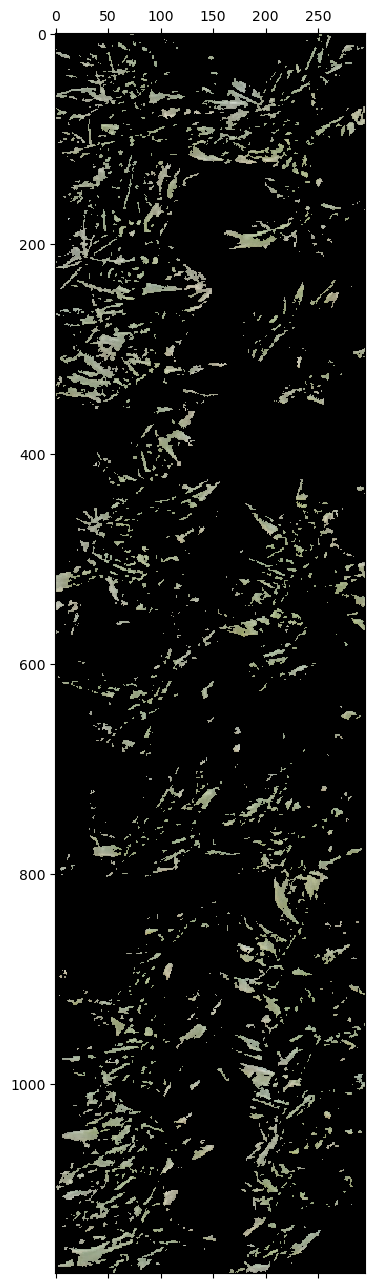

In [102]:
# plot the original image
original_image_path = image_path + '/' + train[0]
    # load the image using keras
img = keras.utils.load_img(original_image_path)
plt.matshow(img)
plt.show()

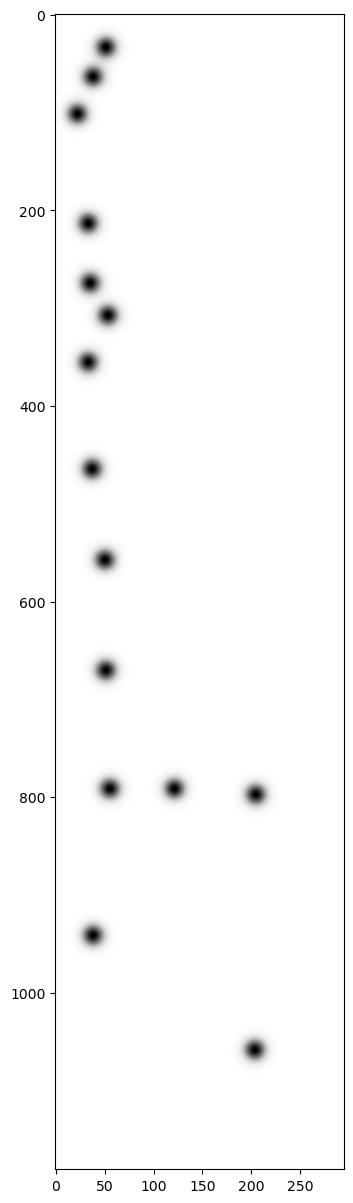

In [88]:
# plot the convolved image
trial_image = convolved_image[0]

plt.figure(figsize = (15,15))
plt.imshow(trial_image, cmap = "Greys")
plt.show()

In [100]:
trial_image.shape

(1181, 295)

In [101]:
img.shape

AttributeError: 'PngImageFile' object has no attribute 'shape'

In [89]:
# now save all the density maps

for j, image in enumerate(convolved_image):
    mat_file_name = (train[j].split("/")[-1]).split('.')[0]
    np.save(store_np_train_path + "/"+ mat_file_name + "_densitymap.npy", image)